In [11]:
import os
os.listdir('/kaggle/working')

['submission.csv', '.virtual_documents']

# 1. Setup and Imports¶

In [12]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from transformers import ViTImageProcessor, ViTModel
import torch

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define paths
base_dir = '/kaggle/input/soil-classification/soil_classification-2025'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_labels_path = os.path.join(base_dir, 'train_labels.csv')
test_ids_path = os.path.join(base_dir, 'test_ids.csv')
submission_path = os.path.join('/kaggle/working', 'submission.csv')

# Define image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 4
class_names = ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# 2. Data Loading and Preprocessing¶

In [13]:
# Load training labels
train_labels = pd.read_csv(train_labels_path)
print("Original training labels shape:", train_labels.shape)
print(train_labels.head())

# Verify all images exist
missing_files = [img_id for img_id in train_labels['image_id'] if not os.path.exists(os.path.join(train_dir, img_id))]
if missing_files:
    print("Missing image files:", missing_files)
    train_labels = train_labels[~train_labels['image_id'].isin(missing_files)]
    print("Removed missing files. New training labels shape:", train_labels.shape)

# Map soil types to numeric labels
label_map = {name: idx for idx, name in enumerate(class_names)}
train_labels['label'] = train_labels['soil_type'].map(label_map)

# Debug: Check for invalid labels
print("Unique labels before cleaning:", train_labels['label'].unique())
print("Missing labels (NaN):", train_labels['label'].isna().sum())
nan_entries = train_labels[train_labels['label'].isna()]
print(nan_entries)

# Load test IDs
test_ids = pd.read_csv(test_ids_path)
print("Test IDs shape:", test_ids.shape)

# Verify test images exist
missing_test_files = [img_id for img_id in test_ids['image_id'] if not os.path.exists(os.path.join(test_dir, img_id))]
if missing_test_files:
    print("Missing test image files:", missing_test_files)
    test_ids = test_ids[~test_ids['image_id'].isin(missing_test_files)]
    print("Removed missing test files. New test IDs shape:", test_ids.shape)

Original training labels shape: (1222, 2)
           image_id      soil_type
0  img_ed005410.jpg  Alluvial soil
1  img_0c5ecd2a.jpg  Alluvial soil
2  img_ed713bb5.jpg  Alluvial soil
3  img_12c58874.jpg  Alluvial soil
4  img_eff357af.jpg  Alluvial soil
Unique labels before cleaning: [0 2 3 1]
Missing labels (NaN): 0
Empty DataFrame
Columns: [image_id, soil_type, label]
Index: []
Test IDs shape: (341, 1)


# 3. Exploratory Data Analysis (EDA)

Class distribution: {'Alluvial soil': 528, 'Red soil': 264, 'Black Soil': 231, 'Clay soil': 199}
Imbalance ratio: 2.65


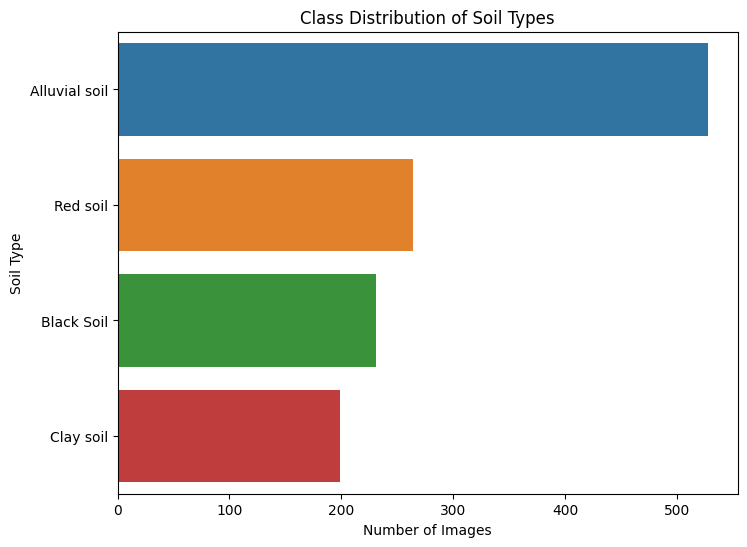

In [14]:
class_counts = train_labels['soil_type'].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"Class distribution: {dict(class_counts)}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.values, y=class_counts.index)
plt.title('Class Distribution of Soil Types')
plt.xlabel('Number of Images')
plt.ylabel('Soil Type')
plt.show()

# 4. Handle Class Imbalance

In [15]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels['label'].dropna().astype(int)),
    y=train_labels['label']
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Split training data into train and validation sets
train_df, val_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels['soil_type'], random_state=42)
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))

Class weights: {0: 0.5785984848484849, 1: 1.3225108225108224, 2: 1.535175879396985, 3: 1.1571969696969697}
Training set size: 977
Validation set size: 245


# 5. ViT Feature Extraction

In [16]:
# Initialize ViT processor and model
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k", trust_remote_code=True)
image_processor.do_rescale = False  # Images are already normalized
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", trust_remote_code=True).to(device)

# Function to load and preprocess image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    return img / 255.0

# Function to extract ViT features
def get_vit_features(image_paths):
    images = []
    valid_paths = []
    for path in image_paths:
        img = load_image(path)
        if img is not None:
            images.append(img)
            valid_paths.append(path)
    if not images:
        return None, []
    inputs = image_processor(images=images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = vit_model(**inputs).last_hidden_state[:, 0, :].cpu().numpy()  # [CLS] token
    return outputs, valid_paths

# Extract features for training and validation sets
train_image_paths = [os.path.join(train_dir, img_id) for img_id in train_df['image_id']]
val_image_paths = [os.path.join(train_dir, img_id) for img_id in val_df['image_id']]

# Process in batches to manage memory
def batch_process_features(image_paths, batch_size=32):
    features = []
    valid_indices = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_features, valid_paths = get_vit_features(batch_paths)
        if batch_features is not None:
            features.append(batch_features)
            valid_indices.extend([image_paths.index(p) for p in valid_paths])
    if not features:
        raise ValueError("No valid features extracted.")
    return np.concatenate(features, axis=0), valid_indices

train_features, train_valid_indices = batch_process_features(train_image_paths)
val_features, val_valid_indices = batch_process_features(val_image_paths)

# Filter labels for valid images
train_labels_filtered = train_df.iloc[train_valid_indices]['label'].values
val_labels_filtered = val_df.iloc[val_valid_indices]['label'].values
print("Train features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)

# Convert labels to one-hot encoding
train_labels_onehot = tf.keras.utils.to_categorical(train_labels_filtered, NUM_CLASSES)
val_labels_onehot = tf.keras.utils.to_categorical(val_labels_filtered, NUM_CLASSES)

Train features shape: (977, 768)
Validation features shape: (245, 768)


# 6. Model Definition and Training

In [17]:
# Define dense classifier
model = Sequential([
    Input(shape=(768,)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# Train the model
history = model.fit(
    train_features,
    train_labels_onehot,
    epochs=100,
    batch_size=BATCH_SIZE,
    validation_data=(val_features, val_labels_onehot),
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ],
    verbose=2
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 230,276 (899.52 KB)

 Trainable params: 230,276 (899.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 - 5s - 75ms/step - accuracy: 0.3849 - loss: 1.3306 - val_accuracy: 0.7918 - val_loss: 1.1494 - learning_rate: 1.0000e-04
Epoch 2/100
62/62 - 0s - 4ms/step - accuracy: 0.6428 - loss: 1.0983 - val_accuracy: 0.8286 - val_loss: 0.9420 - learning_rate: 1.0000e-04
Epoch 3/100
62/62 - 0s - 4ms/step - accuracy: 0.7369 - loss: 0.9105 - val_accuracy: 0.8694 - val_loss: 0.7434 - learning_rate: 1.0000e-04
Epoch 4/100
62/62 - 0s - 4ms/step - accuracy: 0.7912 - loss: 0.7578 - val_accuracy: 0.8857 - val_loss: 0.5859 - learning_rate: 1.0000e-04
Epoch 5/100
62/62 - 0s - 4ms/step - accuracy: 0.8209 - loss: 0.6137 - val_accuracy: 0.9020 - val_loss: 0.4704 - learning_rate: 1.0000e-04
Epoch 6/100
62/62 - 0s - 4ms/step - accuracy: 0.8434 - loss: 0.5047 - val_accuracy: 0.9020 - val_loss: 0.3891 - learning_rate: 1.0000e-04
Epoch 7/100
62/62 - 0s - 4ms/step - accuracy: 0.8782 - loss: 0.4185 - val_accuracy: 0.9265 - val_loss: 0.3319 - learning_rate: 1.0000e-04
Epoch 8/100
62/62 - 0s - 4ms/step

# 7. Evaluation

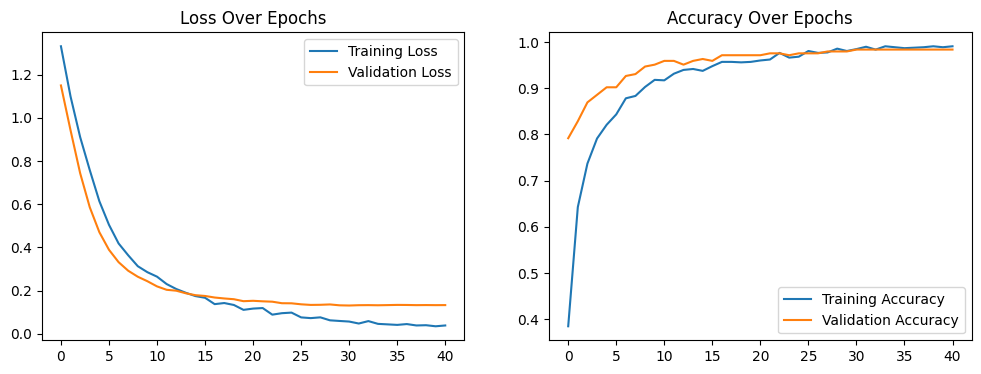

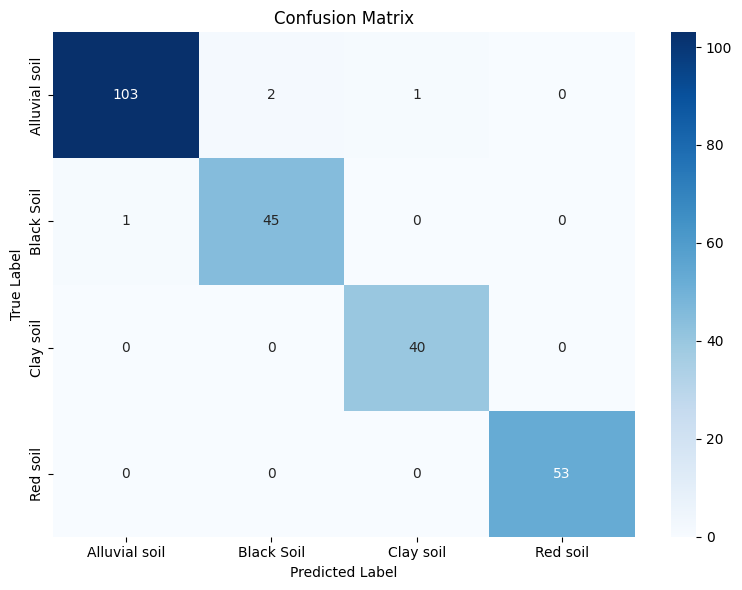

Validation F1-scores: {'Alluvial soil': 0.9809523809523809, 'Black Soil': 0.967741935483871, 'Clay soil': 0.9876543209876543, 'Red soil': 1.0}
Minimum F1-score: 0.9677


In [18]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

# Calculate final metrics and plot confusion matrix
val_predictions = model.predict(val_features, verbose=0)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(val_labels_onehot, axis=1)
f1_scores = f1_score(val_true_labels, val_pred_labels, average=None)
min_f1 = np.min(f1_scores)

# Plot confusion matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"Validation F1-scores: {dict(zip(class_names, f1_scores))}")
print(f"Minimum F1-score: {min_f1:.4f}")

# 8. Test Set Predictions and Submission

In [19]:
# Extract features for test set
test_image_paths = [os.path.join(test_dir, img_id) for img_id in test_ids['image_id']]
test_features, test_valid_indices = batch_process_features(test_image_paths)
print("Test features shape:", test_features.shape)

# Filter test IDs for valid images
test_ids_filtered = test_ids.iloc[test_valid_indices]

# Generate predictions
test_predictions = model.predict(test_features)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_pred_soil_types = [class_names[label] for label in test_pred_labels]

# Create submission DataFrame
submission_df = pd.DataFrame({
    'image_id': test_ids_filtered['image_id'],
    'soil_type': test_pred_soil_types
})

# Save submission
submission_df.to_csv(submission_path, index=False)
print("Submission saved to:", submission_path)

Test features shape: (341, 768)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Submission saved to: /kaggle/working/submission.csv
